In [1]:
# Import the neede libraries
import qiskit
from qiskit import IBMQ
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit import QuantumCircuit, execute, Aer
from qiskit.tools.visualization import plot_histogram
from math import pi as pi
import math
import random

In [2]:
# Load the IBM Quantum Account

MY_API_TOKEN = 'ddc5e3b0b256e5be3237daa8ba467c942e5277418d7f926a73ba99ad513a7b2e70ec780291ebcc096d2a64ff11209fd21ff462378a69a8f38ffc6b344c0ef968' 
IBMQ.save_account(MY_API_TOKEN, overwrite=True)
account = IBMQ.load_account()
print('Credentials loaded')

Credentials loaded


In [3]:
# Get the provider and the backend
provider = IBMQ.get_provider(group='open')
backend = Aer.get_backend('qasm_simulator')

# The Monty Hall problem

The Monty Hall problem is a well-known probability puzzle named after the host of the American television game show "Let's Make a Deal", Monty Hall. The problem goes as follows:

- You are a contestant on a game show. There are three doors, behind one of which is a car, and behind the other two are goats. You choose a door, say Door 1.
- The host, who knows what's behind each door, opens another door, say Door 3, which has a goat. He then asks you if you want to stick with your initial choice (Door 1) or switch to the remaining unopened door (Door 2).
- The question is: Should you switch, stick with your initial choice, or does it not matter?

The counter-intuitive solution is that you should always switch. If you stick with your initial choice, your probability of winning the car is $1/3$. However, if you switch, your probability of winning increases to $2/3$.

Now, let's move on to the quantum world. Quantum computing allows us to create **superpositions of states**, which can be used to simulate the Monty Hall problem in a unique way.

## Three-Qubit W-States on a Quantum Computer

We can represent the three doors as a three-qubit system. The car and the goats can be represented as different states of the qubits. We can then use a $W \text{state}$ quantum circuit <a href="https://demonstrations.wolfram.com/ThreeQubitWStatesOnAQuantumComputer/">[1]</a> to create a superposition of these states. The W state is a specific quantum state of a multi-qubit system that is an equal superposition of the states where exactly one qubit is in the state $|1⟩$ and the rest are in the state $|0⟩$.

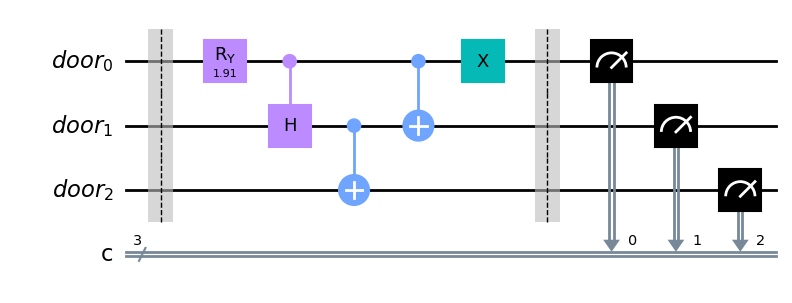

In [4]:
# W states quantum circuit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, circuit_drawer
import numpy as np
from qiskit.quantum_info import Statevector

# Create a quantum circuit with 3 qubits and 3 classical bits
d = QuantumRegister(3,'door')           # Initialization of a 3 qubit quantum register d
c = ClassicalRegister(3, 'c')           # Initialization of a 3 bit classical register c
qc = QuantumCircuit(d,c)                # Initialization of a Quantum circuit composed of d and c

# Initialize the state of the qubits to the W states
theta = 2 * math.acos(1 / math.sqrt(3)) # angle necessary for the Ry gate.

# W-States circuit
qc.barrier()                            # A barrier to identify the start of the circquit
qc.ry(theta,d[0])                       # Rotation gate on y in quibit 0
qc.ch(d[0],d[1])                        # Controlled Hadamard Gate using qubit 0 as control and qubit 1 as target
qc.cx(d[1],d[2])                        # Controlled X gate on qubit 2 using qubit 1 as control
qc.cx(d[0],d[1])                        # Controlled X gate on qubit 1 using qubit 0 as control
qc.x(d[0])                              # X gate on qubit 1
qc.barrier()                            # A barrier to identify the end of the circquit

# Measurement of the qubit
qc.measure(d,c)                         # Measurement of the quantum register on the classical register

# Plot of the circuit
%matplotlib inline                      
qc.draw(output="mpl")

{'001': 3417, '010': 3430, '100': 3393}


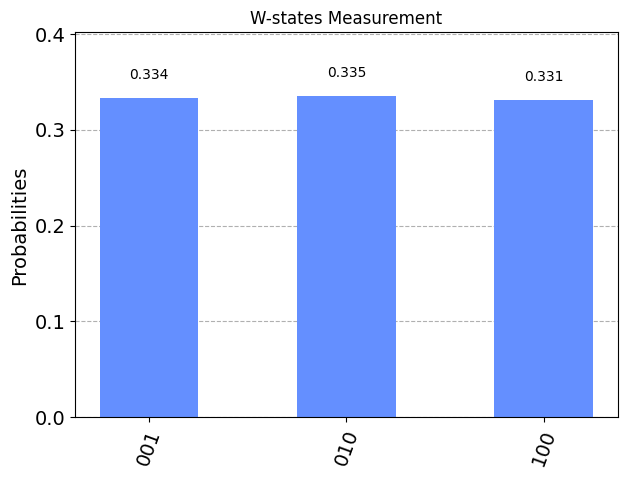

In [5]:
shots_n=1024*10
job = execute(qc, backend, shots=shots_n)
result = job.result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts, title="W-states Measurement")

# Classical Case of the Monty Hall Problem

## Initialization
We start by initializing three qubits in the $|0\rangle$ state, representing the three doors. The car is represented by the state $|1\rangle$ and the goats by the state $|0\rangle$.

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, execute, Aer
import numpy as np

# Create a quantum circuit with 3 qubits
q = QuantumRegister(3,'door')
c = ClassicalRegister(3, 'open')
qc = QuantumCircuit(q,c)

## Contestant Choice:
The contestant chooses a door, in this example, the door 0. This can be represented by initializing the first door to the state $\sqrt{\frac{2}{3}}|0\rangle+\frac{1}{\sqrt{3}}|1\rangle$

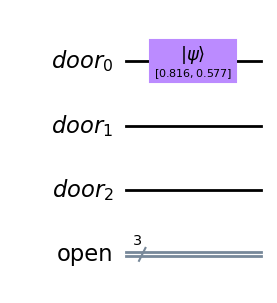

In [7]:
# We prepare the state of the first door to the superposition state 
# where it has 1/3 chance of wining choosing the door 0.

init_state = [math.sqrt(2/3), math.sqrt(1/3)]
qc.initialize(init_state, 0)

%matplotlib inline
qc.draw(output="mpl")

# Host's Reveal:

The host, who knows what's behind each door, opens one of the other two doors to reveal a goat in state $|0\rangle$. This can be represented by applying a $\text{CNOT}$ gate with the first qubit as control and the revealed door as the target followed by a $\text{NOT}$ gate. This ensures that if the first qubit (the contestant's choice) is in state $|1\rangle$ (car), then the other ones will be in to $|0\rangle$ (goat), and if the first qubit is in state $|0\rangle$, one of the others will be in the state $|1\rangle$,simulating the host reveal.

The revealed door is door 2


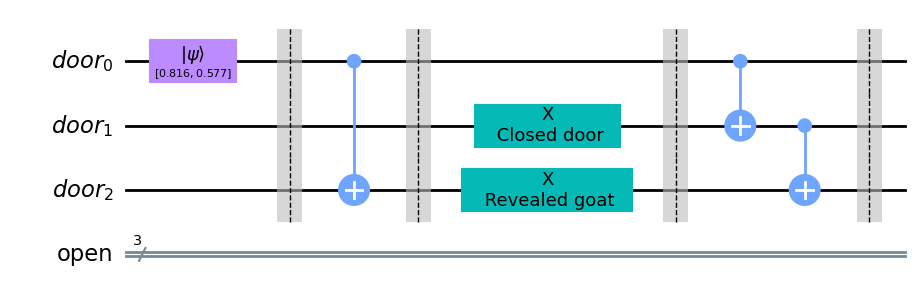

In [8]:
revealed = random.randint(1,2)
print(f"The revealed door is door {revealed}")
qc.barrier()

# Apply a not CNOT gate followed by a NOT gate to the revealed door
for i in range(1,3):
    if i == revealed:
        qc.cx(q[0],q[i])
        qc.barrier()
        qc.x(q[i],label='X\n Revealed goat')
        
    # Apply a cnot gate using the revealed as control and the non choosen as target
for i in range(1,3):
    if i != revealed:
        qc.x(q[i], label='X\n Closed door')
        qc.barrier()
        # Apply CNOT gates
        qc.cx(q[0],q[i])
        qc.cx(q[i],q[revealed])
        qc.barrier()


%matplotlib inline
qc.draw(output="mpl")

# Contestant's Decision:

The contestant the has the option to stick with their original choice or switch to the other unopened door. This can be represented by measuring the choosen door:

{'001': 43824, '010': 87248}


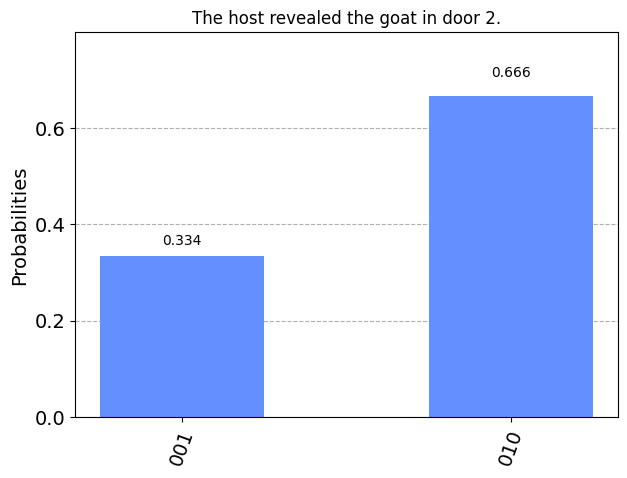

In [9]:
qc.measure(q,c)


shots_n=1024*2**7
job = execute(qc, backend, shots=shots_n)
result = job.result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts, title=f"The host revealed the goat in door {revealed}.")
